In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

np.random.seed(69)

sns.set_theme(style='whitegrid')
%matplotlib inline

# Read Data

In [2]:
gauth = GoogleAuth()
gauth.LocalWebserverAuth()

drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=798038011486-nt63cflppmo0b0iimg5ea687mp7k6fd5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [3]:
file_id = '1ahN_iArFcT6jy6BK56V40fMVag4jp8Qs'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('wrds3.csv')  # saves locally

df = pd.read_csv('wrds3.csv', low_memory = False)

#wrds1.csv has only NYSE stocks
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce")
df["SICCD"] = pd.to_numeric(df["SICCD"], errors="coerce").astype("Int64")
df["PRC"] = df["PRC"].abs()
df.head()

,PERMNO,date,SHRCD,EXCHCD,SICCD,TICKER,COMNAM,PRC,VOL,SHROUT,CFACPR,CFACSHR,NUMTRD
0,10001,2000-01-03,11,3,4920,EWST,ENERGY WEST INC,8.5625,1721.0,2450.0,1.5,1.5,2.0
1,10001,2000-01-04,11,3,4920,EWST,ENERGY WEST INC,8.4375,1080.0,2450.0,1.5,1.5,2.0
2,10001,2000-01-05,11,3,4920,EWST,ENERGY WEST INC,8.5625,1711.0,2450.0,1.5,1.5,5.0
3,10001,2000-01-06,11,3,4920,EWST,ENERGY WEST INC,8.5000,580.0,2450.0,1.5,1.5,2.0
4,10001,2000-01-07,11,3,4920,EWST,ENERGY WEST INC,8.4375,1406.0,2450.0,1.5,1.5,4.0


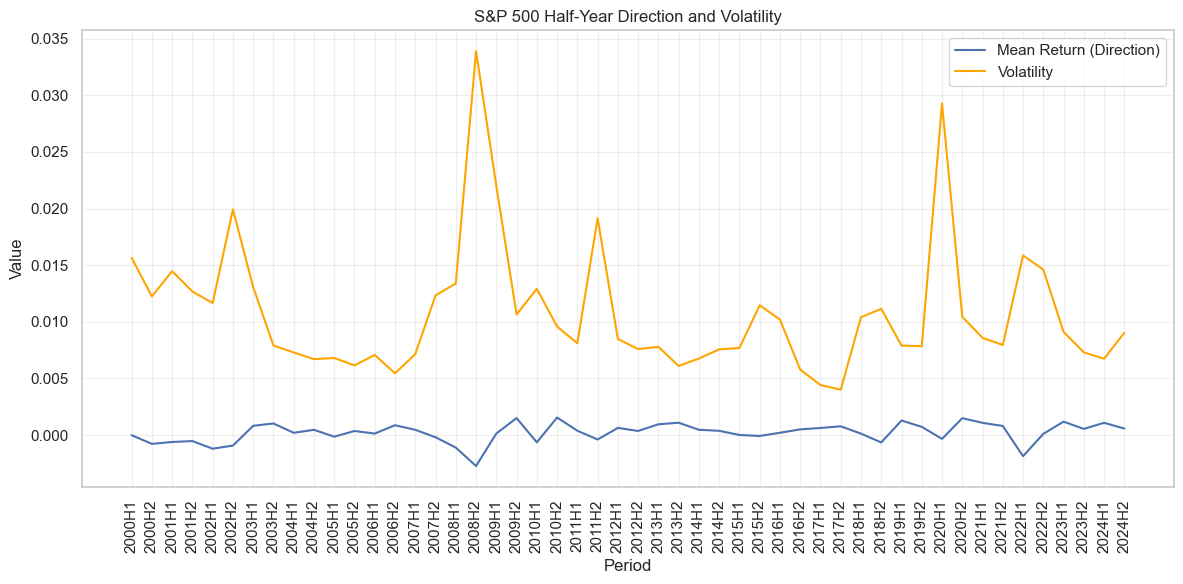

In [4]:
snp = pd.read_csv("wrds_s&p.csv")
snp.rename(columns={"caldt": "date", "spindx": "index"}, inplace=True)
snp["date"] = pd.to_datetime(snp["date"], errors="coerce")
snp["index"] = pd.to_numeric(snp["index"], errors="coerce")

snp["half"] = np.where(snp["date"].dt.month <= 6, "H1", "H2")
snp["period"] = snp["date"].dt.year.astype(str) + snp["half"]

snp = snp.sort_values("date")
snp["log_ret"] = np.log(snp["index"] / snp["index"].shift(1))

snp = snp.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_ret"])

snp_period = (
    snp.groupby("period")["log_ret"]
    .agg(direction="mean", volatility="std")
    .reset_index()
)

snp_period = snp_period.sort_values("period")

plt.figure(figsize=(12,6))
plt.plot(snp_period["period"], snp_period["direction"], label="Mean Return (Direction)")
plt.plot(snp_period["period"], snp_period["volatility"], label="Volatility", color='orange')
plt.xticks(rotation=90)
plt.xlabel("Period")
plt.ylabel("Value")
plt.title("S&P 500 Half-Year Direction and Volatility")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Price Data

In [5]:
price_data = df[["PERMNO", "date", "TICKER", "COMNAM", "NUMTRD"]].copy()
price_data["price"] = abs(df["PRC"]) / df["CFACPR"]
price_data["market_cap"] = (df["SHROUT"] * df["CFACSHR"]) * price_data["price"] * 1000
price_data["vol"] = df["VOL"] * df["CFACSHR"]
# the number is different from the exact number but for the study we need relative numbers
price_data["sic2"] = df["SICCD"] // 100
price_data['half'] = np.where(price_data['date'].dt.month <= 6, 'H1', 'H2')
price_data['period'] = price_data['date'].dt.year.astype(str) + price_data['half']
price_data.columns = [i.lower() for i in price_data.columns]
price_data.drop(["half"], axis=1, inplace=True)
price_data = price_data.sort_values(['ticker', 'date'])
price_data['ret'] = (
    np.log(price_data['price'] / price_data.groupby('ticker')['price'].shift(1))
)
price_data = price_data.sort_values(['date', 'ticker'])
# Remove rows where ret is NaN or infinite
price_data = price_data.replace([np.inf, -np.inf], np.nan).dropna(subset=['ret'])

# numtrd: number of trades is useful to filter thinly traded stocks that might cloud covariance matrices
# vol: filters out tiny illiquid stocks that cannot meaningfully contribute to a portfolio

price_data.head()

# take care of the divide by zero in log warning

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,permno,date,ticker,comnam,numtrd,price,market_cap,vol,sic2,period,ret
10175637,69163,2000-01-03,ACV,ALBERTO CULVER CO,NaN,21.125000,4.800445e+08,6300.0,28,2000H1,0.544513
13752385,80169,2000-01-03,AGM,FEDERAL AGRICULTURAL MORT CORP,NaN,19.312500,1.800118e+08,4100.0,61,2000H1,0.188164
12368168,77881,2000-01-03,BDG,BANDAG INC,NaN,21.437500,2.311391e+08,3200.0,30,2000H1,-0.163684
7082296,29946,2000-01-03,BF,BROWN FORMAN CORP,NaN,6.146667,2.277455e+09,1075312.5,20,2000H1,0.075368
15782627,83443,2000-01-03,BRK,BERKSHIRE HATHAWAY INC DEL,NaN,35.300000,9.428630e+09,873500.0,63,2000H1,-7.347563


In [6]:
company_universe = price_data["ticker"].unique()
print(company_universe)
print(len(company_universe))

['ACV' 'AGM' 'BDG' ... 'NPKI' 'HIT' 'NEUP']
12974


In [7]:
# listing_info = pd.DataFrame()
price_data.head()

,permno,date,ticker,comnam,numtrd,price,market_cap,vol,sic2,period,ret
10175637,69163,2000-01-03,ACV,ALBERTO CULVER CO,NaN,21.125000,4.800445e+08,6300.0,28,2000H1,0.544513
13752385,80169,2000-01-03,AGM,FEDERAL AGRICULTURAL MORT CORP,NaN,19.312500,1.800118e+08,4100.0,61,2000H1,0.188164
12368168,77881,2000-01-03,BDG,BANDAG INC,NaN,21.437500,2.311391e+08,3200.0,30,2000H1,-0.163684
7082296,29946,2000-01-03,BF,BROWN FORMAN CORP,NaN,6.146667,2.277455e+09,1075312.5,20,2000H1,0.075368
15782627,83443,2000-01-03,BRK,BERKSHIRE HATHAWAY INC DEL,NaN,35.300000,9.428630e+09,873500.0,63,2000H1,-7.347563


In [8]:
# First and last observation per firm
summary = price_data.groupby("permno")["date"].agg(first_obs="min", last_obs="max").reset_index()

# Define strict boundaries
start_cutoff = pd.Timestamp("2000-01-03")
end_cutoff   = pd.Timestamp("2024-12-31")

# Extract listing/delisting years only for firms strictly inside the boundaries
summary["listing_year"] = summary.loc[summary["first_obs"] > start_cutoff, "first_obs"].dt.year
summary["delisting_year"] = summary.loc[summary["last_obs"] < end_cutoff, "last_obs"].dt.year

# Count listings and delistings per year
years = range(2000, 2025)
listings = summary["listing_year"].value_counts().reindex(years, fill_value=0)
delistings = summary["delisting_year"].value_counts().reindex(years, fill_value=0)

# Combine into a single dataframe
listing_info = pd.DataFrame({"listings": listings, "delistings": delistings})
listing_info["net_change"] = listing_info["listings"] - listing_info["delistings"]
listing_info.index.name = "year"

print(f"Total listings over period: {listing_info["listings"].sum()}")
print(f"Total delistings over period: {listing_info["delistings"].sum()}")
print(f"Net listing change over period: {listing_info["net_change"].sum()}")

listing_info
# the numbers here might be wrong -- issue might be sorting

Total listings over period: 11976
Total delistings over period: 8364
Net listing change over period: 3612


,listings,delistings,net_change
year,,,
2000,6597,831,5766
2001,167,800,-633
2002,150,521,-371
2003,147,438,-291
2004,261,330,-69
2005,258,331,-73
2006,269,315,-46
2007,269,385,-116
2008,145,328,-183


In [9]:
# total_days = price_data["date"].nunique()

# threshold = 0.75
# required_representation = threshold * total_days

# coverage = (
#     price_data.groupby('permno')['date']
#     .nunique()
#     .reset_index(name = "days_present")
# )
# coverage["relative_representation"] = coverage["days_present"] / total_days

# print(f"Firms with required representation: {len(coverage.query("relative_representation >= @threshold"))}")

# coverage.head()

# # not a good way to do it

# Sampling

In [10]:
def sector(sic):
    if 1 <= sic <= 9:
        return 'Agri/Fish/Forestry'
    elif 10 <= sic <= 14:
        return 'Mining'
    elif 15 <= sic <= 17:
        return 'Construction'
    elif 20 <= sic <= 39:
        return 'Manufacturing'
    elif 40 <= sic <= 49:
        return 'Transp/Comm/Utilities'
    elif 50 <= sic <= 51:
        return 'Wholesale Trade'
    elif 52 <= sic <= 59:
        return 'Retail Trade'
    elif 60 <= sic <= 67:
        return 'Finance/Insurance/RealEstate'
    elif 70 <= sic <= 89:
        return 'Services'
    elif 91 <= sic <= 99:
        return 'Public Admin / Other'
    else:
        return 'Unknown'

price_data['sector'] = price_data['sic2'].apply(lambda x: sector(int(x)) if pd.notnull(x) else 'Unknown')

In [11]:
avg_size  = price_data.groupby('sector')['market_cap'].mean()
total_size = price_data.groupby('sector')['market_cap'].sum()

weights = pd.DataFrame({
    'avg_firm_weight': avg_size / avg_size.sum(),
    'total_market_weight': total_size / total_size.sum()
}).sort_values('total_market_weight', ascending=False)

weights

# if we are sampling n firms at any point, we would want that to look as close to the actual market as possible
# hence weighting by "total market weight" would be a better way than by "average firm size weight"

,avg_firm_weight,total_market_weight
sector,,
Manufacturing,0.139545,0.393445
Services,0.139959,0.194411
Finance/Insurance/RealEstate,0.103499,0.160122
Transp/Comm/Utilities,0.153429,0.093763
Retail Trade,0.146395,0.069619
Public Admin / Other,0.040835,0.038011
Mining,0.112895,0.029554
Wholesale Trade,0.059013,0.015657
Construction,0.051291,0.004516


In [12]:
sector_weights = (
    price_data
    .groupby(['period', 'sector'])['market_cap']
    .sum()
    .reset_index(name='market_cap')
)

sector_weights['weight'] = sector_weights.groupby('period')['market_cap'].transform(lambda x: x / x.sum())

sector_weights = sector_weights[['period', 'sector', 'weight']]

sector_weights.head(15)

,period,sector,weight
0,2000H1,Agri/Fish/Forestry,0.000175
1,2000H1,Construction,0.001440
2,2000H1,Finance/Insurance/RealEstate,0.146419
3,2000H1,Manufacturing,0.470342
4,2000H1,Mining,0.011543
5,2000H1,Public Admin / Other,0.000005
6,2000H1,Retail Trade,0.059895
7,2000H1,Services,0.169382
8,2000H1,Transp/Comm/Utilities,0.128308
9,2000H1,Wholesale Trade,0.012490


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


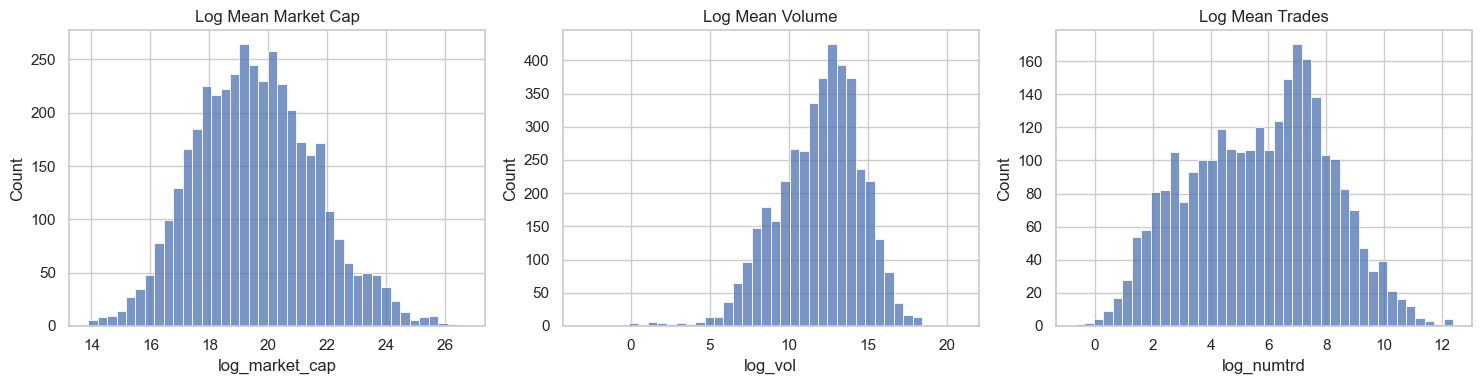

In [13]:
period = "2008H2"

period_data = price_data[price_data['period'] == period]

agg = period_data.groupby('ticker').agg({
    'market_cap': 'mean',    # mean market cap
    'vol': 'mean',           # mean volume 
    'numtrd': 'mean'         # mean number of trades
}).reset_index()

agg['log_market_cap'] = np.log(agg['market_cap'])
agg['log_vol'] = np.log(agg['vol'])
agg['log_numtrd'] = np.log(agg['numtrd'])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(agg["log_market_cap"], bins=40, ax=axes[0])
axes[0].set_title("Log Mean Market Cap")

sns.histplot(agg["log_vol"], bins=40, ax=axes[1])
axes[1].set_title("Log Mean Volume")

sns.histplot(agg["log_numtrd"], bins=40, ax=axes[2])
axes[2].set_title("Log Mean Trades")

plt.tight_layout()
plt.show()

['WGBC', 'ROME', 'IBKC', 'ISBF', 'TWIN', 'CFNL', 'ASBC', 'ISTN', 'MRBK', 'SCBL']


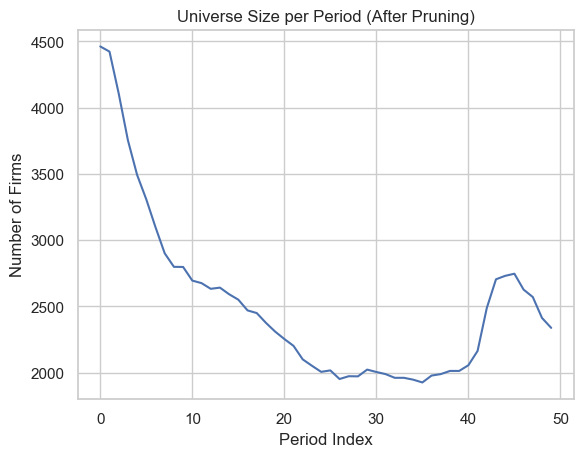

In [14]:
n_total = 250
samples_by_period = {}
universe_size_per_period = []

for period in sector_weights['period'].unique():
    period_weights = sector_weights[sector_weights['period'] == period]

    period_cutoff_data = (
        price_data[price_data['period'] == period]
        .groupby(['ticker', 'sector'])
        .agg({
            'vol': 'mean',
            'numtrd': 'mean'
        })
        .reset_index()
    )

    # period-specific cutoffs
    vol_cutoff = period_cutoff_data['vol'].quantile(0.25)
    trade_cutoff = period_cutoff_data['numtrd'].quantile(0.10)

    # apply pruning
    period_data = price_data[price_data["period"] == period]
    period_data = period_data[
        (period_data['vol'] > vol_cutoff) &
        (period_data['numtrd'] > trade_cutoff)
    ]

    universe_size_per_period.append(period_data["ticker"].nunique())

    # proportional allocation
    sector_n_raw = period_weights['weight'] * n_total
    sector_n_floor = sector_n_raw.astype(int)
    leftover = n_total - sector_n_floor.sum()
    remainders = sector_n_raw - sector_n_floor
    if leftover > 0:
        extra_idx = remainders.nlargest(leftover).index
        sector_n_floor.loc[extra_idx] += 1

    sampled_tickers = []
    for idx, row in period_weights.iterrows():
        sector = row['sector']
        n_sample = sector_n_floor.loc[idx]
        sector_firms = period_data[period_data['sector'] == sector]['ticker'].unique()
        n_sample = min(len(sector_firms), n_sample)
        if n_sample > 0:
            sampled = np.random.choice(sector_firms, size=n_sample, replace=False)
            sampled_tickers.extend(sampled)

    samples_by_period[period] = sampled_tickers
print(samples_by_period['2000H1'][:10])   # first few tickers from 2000H1
sns.lineplot(x=range(len(universe_size_per_period)), y=universe_size_per_period)
plt.title("Universe Size per Period (After Pruning)")
plt.xlabel("Period Index")
plt.ylabel("Number of Firms")
plt.show()

# Early sharp drop (2000 – 2003)	
# That’s the dot‑com collapse + “penny stock flush”. Thousands of NASDAQ issues were delisted or went illiquid. Your quantile‑based filters eliminate them, producing the plunge from ~4,500 → ~2,500.
# Gradual downward slope (2004 – 2015ish)	
# Real contraction in U.S. listings: mergers, tighter listing standards, post‑SOX delistings, and fewer IPOs. CRSP data show this decline in actual counts too.
# Small uptick around Index ≈ 40 (≈ 2020 – 2022)	
# Post‑COVID / SPAC / IPO‑boom surge. You’re capturing that wave of new small‑cap and SPAC listings with sufficient trading activity.
# Recent taper	
# Many of those 2021 listings thinned out or merged again.

In [15]:
# {period: len(tickers) for period, tickers in samples_by_period.items()}
{k: len(v) for k, v in samples_by_period.items() if len(v) != 250} # check if every period has 250 tickers in the sample

{}

# Market Trend: Bundle Direction & Volatility

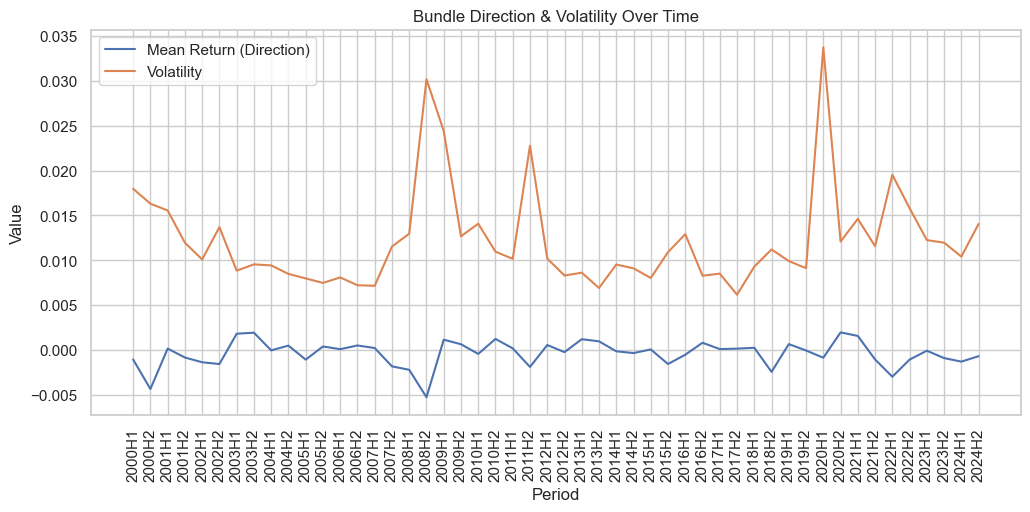

In [16]:
direction_by_period = []
volatility_by_period = []

# other ways to get directionality is a weighted average (not a fan) and PC1
for period, tickers in samples_by_period.items():
    dfp = price_data[(price_data['period'] == period) &
                     (price_data['ticker'].isin(tickers))]
    
    mean_ret = dfp.groupby('date')['ret'].mean()  # average across stocks for each day
    direction_by_period.append(mean_ret.mean())  # mean over the period
    volatility_by_period.append(mean_ret.std())  # strength of moves

periods_sorted = sorted(samples_by_period.keys())
plt.figure(figsize=(12,5))
plt.plot(periods_sorted, direction_by_period, label='Mean Return (Direction)')
plt.plot(periods_sorted, volatility_by_period, label='Volatility')
plt.xticks(rotation=90)
plt.xlabel("Period")
plt.ylabel("Value")
plt.title("Bundle Direction & Volatility Over Time")
plt.legend()
plt.grid(True)
plt.show()

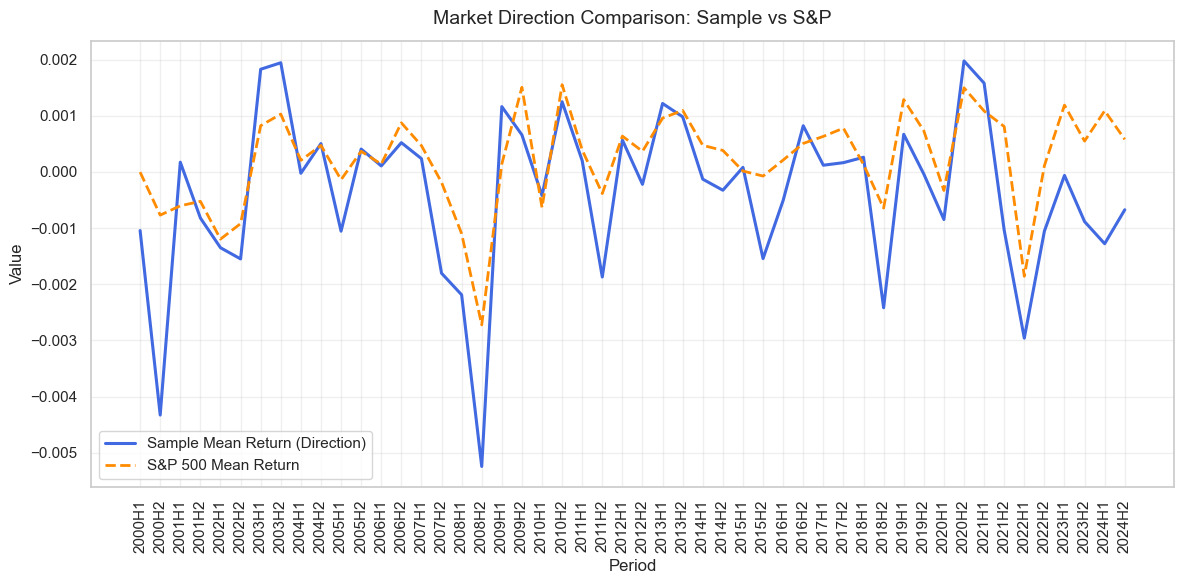

In [17]:
direction_arr = np.array(direction_by_period)
snp_arr = np.array(snp_period["direction"])

plt.figure(figsize=(12,6))
plt.plot(periods_sorted, direction_arr, label='Sample Mean Return (Direction)', color='royalblue', linewidth=2.2)
plt.plot(periods_sorted, snp_arr, label='S&P 500 Mean Return', color='darkorange', linestyle='--', linewidth=2)

plt.xticks(rotation=90)
plt.xlabel('Period', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Market Direction Comparison: Sample vs S&P', fontsize=14, pad=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation Matrix Per Period

In [19]:
from sklearn.covariance import LedoitWolf

corr_by_period = {}
lw = LedoitWolf()

for period, tickers in samples_by_period.items():
    dfp = price_data[(price_data['period'] == period) &
                     (price_data['ticker'].isin(tickers))]

    # aggregate to ensure uniqueness
    dfp_agg = dfp.groupby(['date', 'ticker'])['ret'].mean().reset_index()

    # pivot to wide format
    ret_wide = dfp_agg.pivot(index='date', columns='ticker', values='ret')
    ret_wide = ret_wide.fillna(0)

    X = ret_wide.values

    # check tickets with zero variance that causes dimension inconsistency
    # X_std = X.std(axis=0)
    # zero_var_tickers = ret_wide.columns[X_std == 0]
    # print(f"{period}: tickers with zero variance:", list(zero_var_tickers)) 

    if X.shape[0] < 2:
        print(f"Skipping {period}, insufficient data")
        continue

    lw.fit(X)
    cov = pd.DataFrame(lw.covariance_, index=ret_wide.columns, columns=ret_wide.columns)
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr_by_period[period] = pd.DataFrame(corr, index=ret_wide.columns, columns=ret_wide.columns)

In [20]:
corr_by_period
# ensure all matrices are of the same dimension

corr_sizes = pd.DataFrame(
    [(p, *m.shape) for p, m in corr_by_period.items()],
    columns=["period", "n_rows", "n_cols"]
)

corr_sizes["less_than_250"] = corr_sizes["n_rows"] < 250

print("\nPeriods with fewer than 250 tickers:")
print(corr_sizes[corr_sizes["less_than_250"]])


Periods with fewer than 250 tickers:
    period  n_rows  n_cols  less_than_250
4   2002H1     248     248           True
15  2007H2     249     249           True


In [21]:
period = "2007H2"
expected = set(samples_by_period[period])
actual = set(corr_by_period[period].columns)
missing = expected - actual
print(f"Missing tickers for {period}: {missing}")

Missing tickers for 2007H2: set()


# Visualization
Degree Distribution, Correlation, Eigenvalue Spectrum

In [50]:
from scipy.sparse import csgraph

test_range = ["2000H1", "2007H2", "2008H1", "2008H2"]

for period in test_range:

    corr = corr_by_period[period]
    A = abs(corr.values)
    A[A < 0.1] = 0  # thresholding weak correlations
    # normalized Laplacian
    L_norm = csgraph.laplacian(A, normed=True)

    # eigenvalues
    eigvals = np.linalg.eigvalsh(L_norm)

    print(eigvals[1])

-6.876560232026621e-16
-6.161107683726892e-16
-7.660988921663621e-16
-2.220446049250313e-16


In [51]:
avg_deg = []
med_deg = []
p95_deg = []

periods_sorted = corr_by_period.keys()

for period in periods_sorted:
    A = np.abs(corr_by_period[period].values)
    A[A < 0.1] = 0
    deg = A.sum(axis=1)
    avg_deg.append(deg.mean())
    med_deg.append(np.median(deg))
    p95_deg.append(np.percentile(deg, 95))

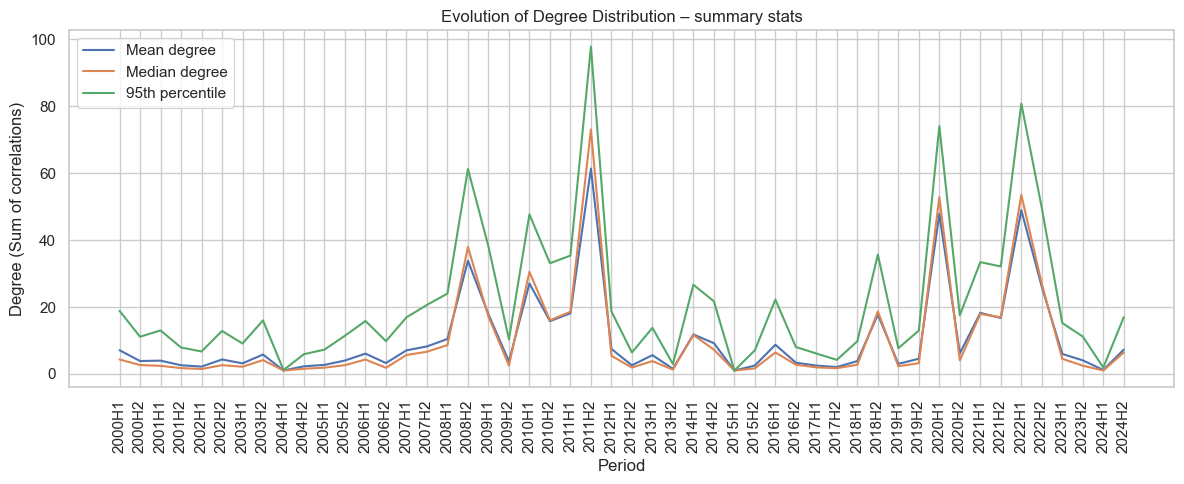

In [52]:
plt.figure(figsize=(12,5))
plt.plot(periods_sorted, avg_deg, label='Mean degree')
plt.plot(periods_sorted, med_deg, label='Median degree')
plt.plot(periods_sorted, p95_deg, label='95th percentile')
plt.xticks(rotation=90)
plt.ylabel("Degree (Sum of correlations)")
plt.xlabel("Period")
plt.title("Evolution of Degree Distribution – summary stats")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

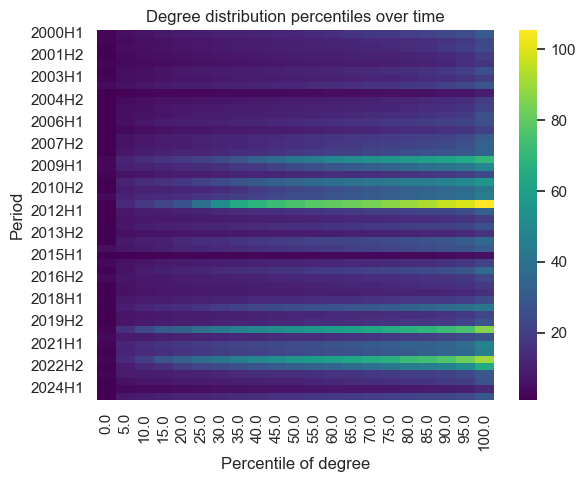

In [53]:
P = np.linspace(0, 100, 21)
heat = [
    np.percentile(
        np.abs(corr_by_period[p].values).sum(axis=1), P
    ) for p in periods_sorted
]
sns.heatmap(pd.DataFrame(heat, index=periods_sorted, columns=P),
            cmap="viridis")
plt.title("Degree distribution percentiles over time")
plt.xlabel("Percentile of degree")
plt.ylabel("Period")
plt.show()

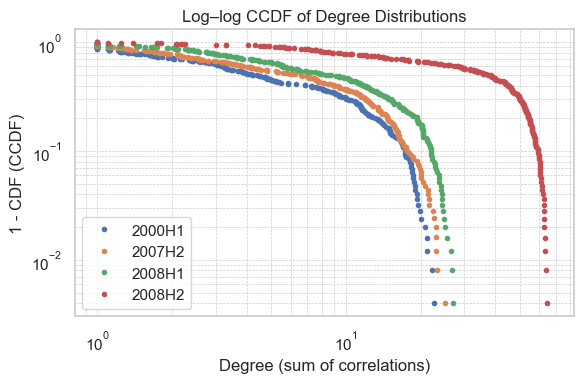

In [54]:
plt.figure(figsize=(6,4))

for period in test_range:
    if period not in corr_by_period:
        continue

    # adjacency matrix from correlations
    A = np.abs(corr_by_period[period].values)
    A[A < 0.1] = 0  # threshold weak links
    degrees = A.sum(axis=1)

    # sort and compute CCDF
    deg_sorted = np.sort(degrees)
    ccdf = 1.0 - np.arange(1, len(deg_sorted)+1) / len(deg_sorted)

    # plot on log–log scale
    plt.loglog(deg_sorted, ccdf, marker='.', linestyle='none', label=period)

plt.xlabel("Degree (sum of correlations)")
plt.ylabel("1 - CDF (CCDF)")
plt.title("Log–log CCDF of Degree Distributions")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

# x‑axis (Degree / Sum of correlations) → how “connected” a stock is (its total link strength to others).
# y‑axis (1 − CDF) → fraction of nodes with degree greater than or equal to x.

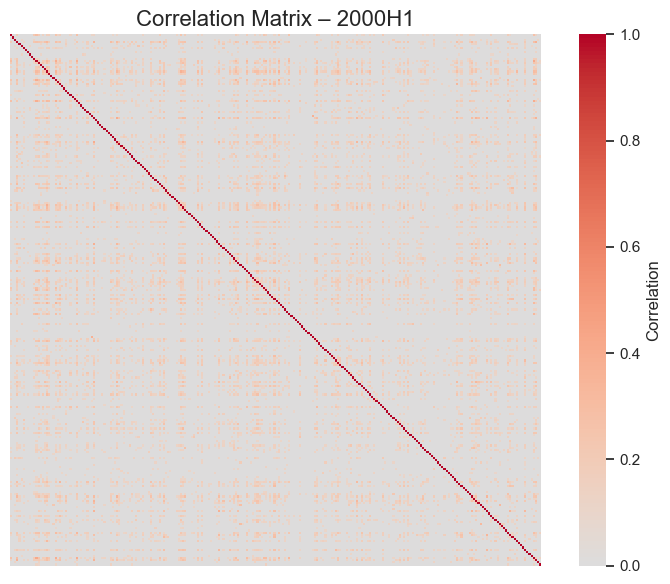

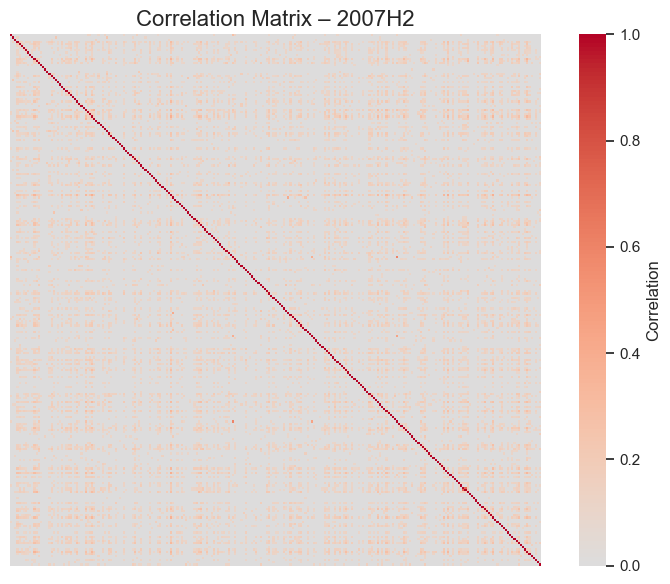

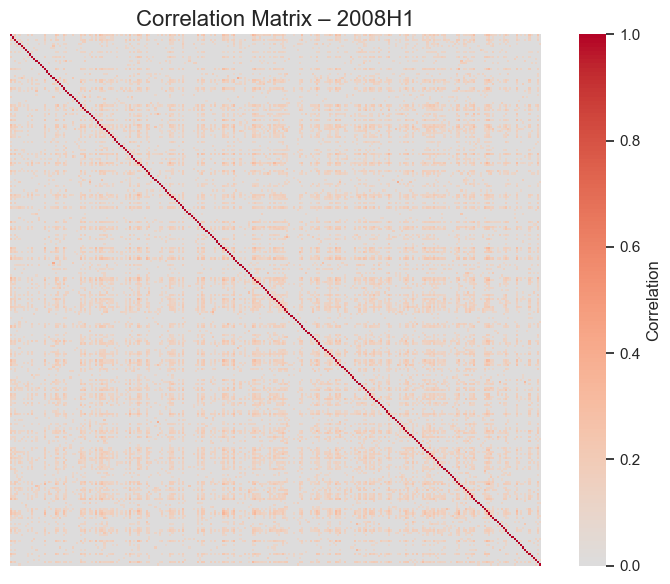

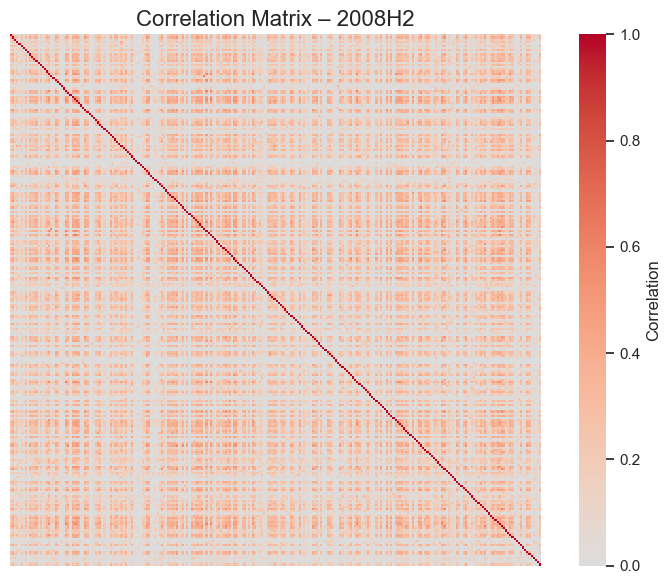

In [55]:
for period in test_range:
    corr = corr_by_period[period]

    # make sure correlation matrix is numeric only
    A = abs(corr.values.astype(float))
    A[A < 0.1] = 0  # thresholding weak correlations
    # create figure
    plt.figure(figsize=(8, 6))

    # draw the heatmap
    sns.heatmap(
        A,
        cmap="coolwarm",      # red = positive, blue = negative
        center=0,             # center colormap at zero
        cbar_kws={'label': 'Correlation'},
        square=True,
        xticklabels=False,    # hide labels if large
        yticklabels=False
    )

    plt.title(f"Correlation Matrix – {period}", fontsize=16)
    plt.tight_layout()
    plt.show()


=== 2000H1 ===


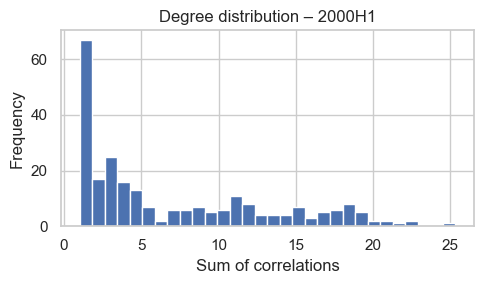

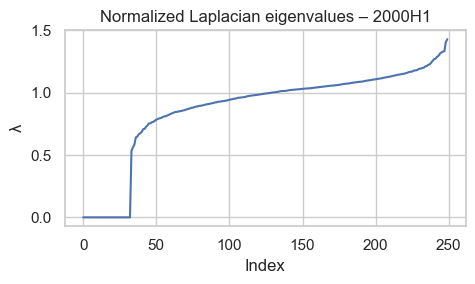

First few λ: [-7.35326663e-16 -6.87656023e-16 -6.50019024e-16 -5.40032048e-16
 -4.92646825e-16 -4.73516815e-16 -3.67941492e-16 -2.93197211e-16
 -2.28482936e-16 -2.06451880e-16 -1.37702127e-16 -6.88006810e-17
 -2.32171651e-17 -9.34573267e-33  4.93205856e-34  1.37334798e-32
  5.34033112e-32  7.27044597e-18  1.98169248e-17  1.06617462e-16]

=== 2007H2 ===


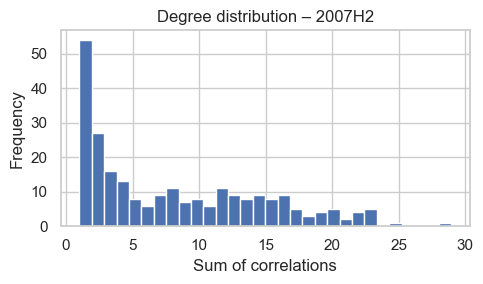

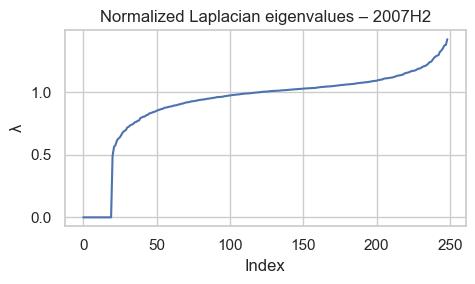

First few λ: [-8.31960749e-16 -6.16110768e-16 -4.17431440e-16 -3.12981386e-16
 -2.46404436e-16 -2.39426673e-16 -2.99162060e-17 -2.61629839e-17
  1.48502612e-17  1.84346095e-17  9.60526391e-17  2.29562068e-16
  3.28122300e-16  3.99534797e-16  4.20138591e-16  5.03472975e-16
  5.50356326e-16  6.07950018e-16  7.48511763e-16  8.04390021e-16]

=== 2008H1 ===


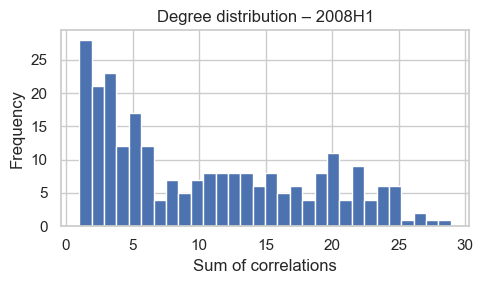

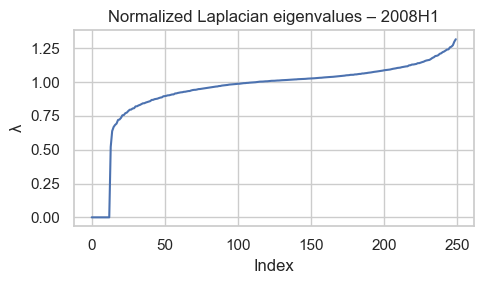

First few λ: [-1.55492087e-15 -7.66098892e-16 -6.84849529e-16 -4.02483076e-16
  1.07268851e-16  2.13177453e-16  3.79165720e-16  4.44089210e-16
  4.46459476e-16  6.87758354e-16  1.29483729e-15  1.34331389e-15
  2.04499580e-15  5.20676364e-01  6.38014930e-01  6.68405417e-01
  6.83551926e-01  6.93287957e-01  7.20116281e-01  7.23448396e-01]

=== 2008H2 ===


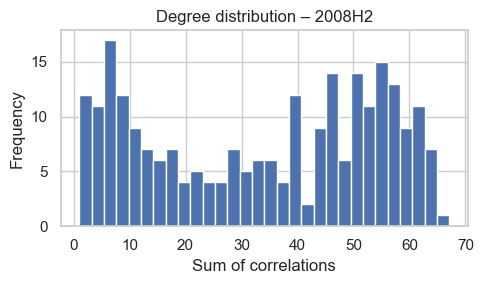

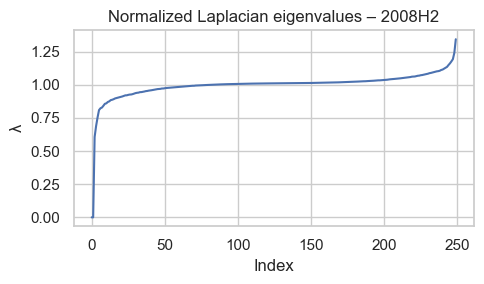

First few λ: [-4.44089210e-16 -2.22044605e-16  6.05912993e-01  6.88260735e-01
  7.52626506e-01  8.08696071e-01  8.22416843e-01  8.27766750e-01
  8.41199197e-01  8.55993274e-01  8.59497733e-01  8.69650192e-01
  8.74434113e-01  8.83678029e-01  8.86541232e-01  8.90826150e-01
  8.96610900e-01  8.99489671e-01  9.03051438e-01  9.04944013e-01]


In [56]:
from scipy.sparse.csgraph import laplacian

for period in test_range:
    if period not in corr_by_period:
        print(f"{period}: not found in corr_by_period, skipping")
        continue

    print(f"\n=== {period} ===")
    # adjacency matrix from correlations
    A = np.abs(corr_by_period[period].values)
    A[A < 0.1] = 0  # threshold weak correlations

    # ---- degree distribution ----
    degrees = A.sum(axis=1)
    plt.figure(figsize=(5,3))
    plt.hist(degrees, bins=30)
    plt.title(f"Degree distribution – {period}")
    plt.xlabel("Sum of correlations")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # ---- eigenvalue spectrum ----
    eigvals = np.linalg.eigvalsh(laplacian(A, normed=True))
    plt.figure(figsize=(5,3))
    plt.plot(sorted(eigvals))
    plt.title(f"Normalized Laplacian eigenvalues – {period}")
    plt.xlabel("Index")
    plt.ylabel("λ")
    plt.tight_layout()
    plt.show()

    print("First few λ:", eigvals[:20])

# Clustering

In [57]:
from fiedler_cut import *
import networkx as nx

A = np.abs(corr_by_period["2008H1"].values)
A[A < 0.1] = 0

G = nx.from_numpy_array(A)

# get connected components
components = list(nx.connected_components(G))

print(f"Found {len(components)} disconnected components.")
for i, comp in enumerate(components):
    print(f"Component {i}: size={len(comp)}")

Found 13 disconnected components.
Component 0: size=238
Component 1: size=1
Component 2: size=1
Component 3: size=1
Component 4: size=1
Component 5: size=1
Component 6: size=1
Component 7: size=1
Component 8: size=1
Component 9: size=1
Component 10: size=1
Component 11: size=1
Component 12: size=1


In [58]:
core_nodes = np.array(list(max(components, key=len)), dtype=int)
A_core = A[np.ix_(core_nodes, core_nodes)]

In [59]:
A_core.shape

(238, 238)

In [60]:
fiedler_values = []

for comp in components:
    idx = np.array(list(comp))
    A_sub = A[np.ix_(idx, idx)]
    
    # compute Fiedler value
    lambda2 = compute_fiedler_value(A_sub, normalized=True)
    fiedler_values.append(lambda2)
    
    print(f"Cluster {i}: size={len(comp)}, λ₂={lambda2:.4f}")

Cluster 12: size=238, λ₂=0.5207
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan
Cluster 12: size=1, λ₂=nan


In [61]:
clusters = []

for comp in components:
    comp_nodes = np.array(list(comp))
    clusters += recursive_fiedler(
        A, nodes=comp_nodes,
        normalized=True,
        lambda2_thresh=None,
        conductance_thresh=0.5,
        verbose=False
    )

len(clusters)

13

In [62]:
import igraph as ig
import leidenalg as la

g = ig.Graph.Weighted_Adjacency(A_core.tolist(), mode="UNDIRECTED", loops=False)

# perform Leiden algorithm (returns vertex partition)
partition = la.find_partition(g, la.RBConfigurationVertexPartition, weights=g.es["weight"])

# community labels for each node
labels = np.array(partition.membership)

# number of detected communities
n_communities = len(set(labels))
print(f"Leiden found {n_communities} communities.")

sizes = pd.Series(labels).value_counts().sort_index()
print(sizes)

Leiden found 3 communities.
0    95
1    77
2    66
Name: count, dtype: int64


In [63]:
core_tickers = corr_by_period["2008H1"].columns[core_nodes]

import pandas as pd
community_df = pd.DataFrame({
    "ticker": core_tickers,
    "community": labels
})
print(community_df.head())

  ticker  community
0   ABFS          1
1   ACAP          1
2   ACLI          1
3   ADEP          2
4   AFFY          0


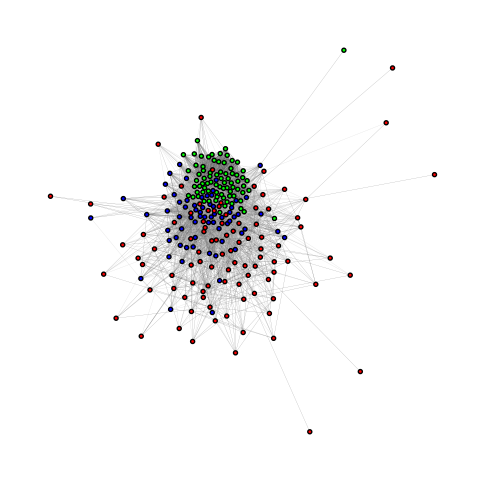

In [64]:
layout = g.layout("fr")  # Force-directed layout
fig, ax = plt.subplots(figsize=(6,6))
ig.plot(
    partition,
    target=ax,
    layout=layout,
    vertex_size=4,
    vertex_color=labels,
    edge_width=0.1,
)
plt.show()